<a href="https://colab.research.google.com/github/ZacharyZekaiXu/ZekaiXu_CrossmodalRecognition/blob/main/PusherTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Workflow for Tactile-Visual Crossmodal Push task

Discription: a robot (Pointrover or equivalent Gripper to push a cube or shpere to corresponding target position)

In [ ]:

!pip install tensorflow==1.13.2

In [1]:

!pip install --upgrade pybullet==3.1.6 imageio-ffmpeg stable-baselines

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML
from stable_baselines.sac.policies import MlpPolicy
from stable_baselines import SAC
import gym
from gym import spaces

np.set_printoptions(precision=3)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pybullet-3.1.6-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 1.6 MB 14.8 MB/s 
  Attempting uninstall: pybullet
    Found existing installation: pybullet 3.1.0
    Uninstalling pybullet-3.1.0:
      Successfully uninstalled pybullet-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tactile-gym 0.0.1 requires pybullet==3.1.0, but you have pybullet 3.1.6 which is incompatible.
panda-gym 2.0.4 requires gym<=0.23,>=0.22, but you have gym 0.21.0 which is incompatible.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# Write custom robot URDF. See http://wiki.ros.org/urdf/Tutorials

urdf_str = '''
<?xml version="1.0"?>
<robot name="myrobot">
  <link name="base_link">
    <visual>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
      <material name="blue">
        <color rgba="0 0 .8 1"/>
      </material>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="arm">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="white">
        <color rgba="0.8 0.8 .8 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="base_to_arm" type="revolute">
    <parent link="base_link"/>
    <child link="arm"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="arm2">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="red">
        <color rgba="0.8 0.2 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm_to_arm2" type="revolute">
    <parent link="arm"/>
    <child link="arm2"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="end_effector">
    <visual>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <material name="greeb">
        <color rgba="0.2 0.8 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm2_to_end_effector" type="revolute">
    <parent link="arm2"/>
    <child link="end_effector"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

</robot>
'''

with open('custom_robot.urdf', 'w') as f:
    f.write(urdf_str)

In [3]:
# init pybullet
p.connect(p.DIRECT) # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

# setup environment with robot
plane_id = p.loadURDF("plane.urdf")
robot_id = p.loadURDF("custom_robot.urdf", basePosition=[1.400000, -0.200000, 0.650000], useFixedBase=True)
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
cube_id = p.loadURDF("cube.urdf", basePosition=[1.1, -0.2, 0.675], globalScaling=0.1)

num_joints = p.getNumJoints(robot_id)
print('Num of joints in robot:', num_joints)

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

class PusherEnv(gym.Env):
    """Custom environment to train an agent to push an object"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(PusherEnv, self).__init__()

        # Observation is the current end effector position, cube position, and target cube position
        self.observation_space = spaces.Box(low=-3, high=3, shape=(3*3,), dtype=np.float32)

        # action is the vector of (x, y) end-effector velocities
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)
    
    def _get_end_effector_pos(self):
        end_effector_pos = p.getLinkState(bodyUniqueId=robot_id, linkIndex=2)[0]
        return np.array(end_effector_pos)
    
    def _get_cube_pos(self):
        cube_pos = p.getBasePositionAndOrientation(cube_id)[0]
        return np.array(cube_pos)
    
    def _get_obs(self):
        current_end_effector_pos = self._get_end_effector_pos()
        current_cube_pos = self._get_cube_pos()
        target_cube_pos = np.array(self.target_pos) # target position of cube
        return np.concatenate([current_end_effector_pos, current_cube_pos, target_cube_pos])

    def reset(self):
        self.t = 0
        self.start_pos = [1.1, -0.2 + np.random.uniform(-0.35, 0.35), 0.7] # goal is to push this target
        self.target_pos = [self.start_pos[0], self.start_pos[1]-1.0, self.start_pos[2]] # target position to push cube to

        for j in range(num_joints):
            p.resetJointState(bodyUniqueId=robot_id, jointIndex=j, targetValue=0, targetVelocity=0)
            p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=0)

        p.resetBasePositionAndOrientation(cube_id, self.start_pos, [0.0, 0.0, 0.0, 1.0])
        
        for _ in range(5):
            p.stepSimulation() # step a couple of times to make there is no weirdness after resetting
        
        obs = self._get_obs()
        return obs

    def step(self, action):
        # Execute one time step within the environment

        end_effector_pos = self._get_end_effector_pos()

        next_end_effector_pos = [end_effector_pos[0]+action[0], end_effector_pos[1]+action[1], end_effector_pos[2]]
        next_end_effector_orn = p.getQuaternionFromEuler([math.pi, 0, 0])
        joint_poses = p.calculateInverseKinematics(robot_id, 2, next_end_effector_pos, next_end_effector_orn)

        for j in range(num_joints):
            p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j])
        
        for _ in range(8):
            p.stepSimulation() # step by 1.0/240 seconds
            self.t += 1

        obs = self._get_obs()
        
        current_cube_pos = self._get_cube_pos()
        #print(end_effector_pos, action, current_cube_pos, self.target_pos)

        reward = -sum(abs(pi-ti) for pi, ti in zip(current_cube_pos[:2], self.target_pos[:2]))
        reward += -sum(abs(pi-ti) for pi, ti in zip(current_cube_pos[:2], end_effector_pos[:2]))

        done = (self.t >= 4800)

        return obs, reward, done, {}
    
    def render(self):
        # render image
        #print(p.getLinkState(bodyUniqueId=robot_id, linkIndex=2)[0])
        #print(self._get_cube_pos(), self.target_pos)
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        image = np.ascontiguousarray(image)
        return image

env = PusherEnv()

model = SAC(MlpPolicy, env, verbose=0)
model.learn(total_timesteps=15000, log_interval=10000)
model.save("sac_pusher_env")

del model # remove to demonstrate saving and loading

model = SAC.load("sac_pusher_env")

vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

# Enjoy trained agent
for i in range(1):
    obs = env.reset()
    for j in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        image = env.render()
        vid.send(image)
        if done:
            break

vid.close()
p.disconnect()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


Num of joints in robot: 3


Instructions for updating:
Use tf.cast instead.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Play recorded video

mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

# (Trivial no need to run)attach a two fingered jaw gripper to the Kuka robot
to pick-and-place objects

In [7]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


timestep 749...

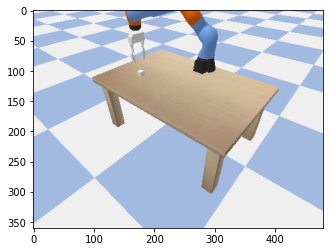

In [8]:
p.connect(p.DIRECT) #or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-10)

plane_id = p.loadURDF("plane.urdf")
kuka_id = p.loadURDF("kuka_iiwa/model_vr_limits.urdf", 1.400000, -0.200000, 0.600000, 0.000000, 0.000000, 0.000000, 1.000000)
kuka_gripper_id = p.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
cube_id = p.loadURDF("cube.urdf", basePosition=[0.85, -0.2, 0.65], globalScaling=0.05)

# attach gripper to kuka arm
kuka_cid = p.createConstraint(kuka_id, 6, kuka_gripper_id, 0, p.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0])
kuka_cid2 = p.createConstraint(kuka_gripper_id, 4, kuka_gripper_id, 6, jointType=p.JOINT_GEAR, jointAxis=[1,1,1], parentFramePosition=[0,0,0], childFramePosition=[0,0,0])
p.changeConstraint(kuka_cid2, gearRatio=-1, erp=0.5, relativePositionTarget=0, maxForce=100)

# reset kuka
jointPositions = [-0.000000, -0.000000, 0.000000, 1.570793, 0.000000, -1.036725, 0.000001]
for jointIndex in range(p.getNumJoints(kuka_id)):
    p.resetJointState(kuka_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

# reset gripper
p.resetBasePositionAndOrientation(kuka_gripper_id, [0.923103, -0.200000, 1.250036], [-0.000000, 0.964531, -0.000002, -0.263970])
jointPositions = [0.000000, -0.011130, -0.206421, 0.205143, -0.009999, 0.000000, -0.010055, 0.000000]
for jointIndex in range(p.getNumJoints(kuka_gripper_id)):
    p.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_gripper_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

num_joints = p.getNumJoints(kuka_id)
kuka_end_effector_idx = 6

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

#video = cv2.VideoWriter('vid.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (cam_width, cam_height)) # Does not seem to support h264!
vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

for t in range(750):
    print(f'\rtimestep {t}...', end='')

    if t % 8 == 0: # PyBullet default simulation time step is 240fps, but we want to record video at 30fps.
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        #video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        vid.send(np.ascontiguousarray(image))
    
    target_pos, gripper_val = [0.85, -0.2, 0.97], 0
    if t >= 150 and t < 250:
        target_pos, gripper_val = [0.85, -0.2, 0.97], 1 # grab object
    elif t >= 250 and t < 400:
        target_pos, gripper_val = [0.85, -0.2, 0.97 + 0.13*(t-250)/150.], 1 # move up after picking object
    elif t >= 400 and t < 600:
        target_pos, gripper_val = [0.85, -0.2 + 0.4*(t-400)/200., 1.1], 1 # move to target position
    elif t >= 600 and t < 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 1 # stop at target position
    elif t >= 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 0 # drop object

    target_orn = p.getQuaternionFromEuler([0, 1.01*math.pi, 0])
    joint_poses = p.calculateInverseKinematics(kuka_id, kuka_end_effector_idx, target_pos, target_orn)
    for j in range (num_joints):
        p.setJointMotorControl2(bodyIndex=kuka_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j])
    
    p.setJointMotorControl2(kuka_gripper_id, 4, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=100)
    p.setJointMotorControl2(kuka_gripper_id, 6, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=100)

    p.stepSimulation()

plt.imshow(Image.fromarray(image)) # show the last frame

vid.close()
#video.release()
p.disconnect()

In [9]:
# Play recorded video
#os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

# Import Tactile Senosr Unit (to BeeRover or Gripper) from Tactile Gym 2.0

In [14]:
!pip install git+https://github.com/ac-93/tactile_gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ac-93/tactile_gym.git to /tmp/pip-req-build-dcu0y0s4
  Running command git clone -q https://github.com/ac-93/tactile_gym.git /tmp/pip-req-build-dcu0y0s4
     |████████████████████████████████| 76.3 MB 9.4 kB/s 
     |████████████████████████████████| 177 kB 78.8 MB/s 
     |████████████████████████████████| 1.5 MB 75.0 MB/s 
  Created wheel for tactile-gym: filename=tactile_gym-0.0.1-py3-none-any.whl size=21397910 sha256=fd550f3378c55bf764a77c0b1666bd3f6d194fd8d072a02590f6c78dfe3ceca6
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7x9x1rh/wheels/8e/7b/73/4ec3d73b8b8f6ff659f1d23a137380dfe5d2d48a6028f38bbd
  Created wheel for pybullet: filename=pybullet-3.1.0-cp37-cp37m-linux_x86_64.whl size=89151889 sha256=4309166449ea9acfeccfac00626d1985b948146a2a5d2353f85c3f80dc312b3c
  Stored in directory: /root/.cache/pip/wheels/38/3f/68/494790c38a575dec99c27d6d2af68fe8

# Panda Gym

In [11]:
#importing dependencies
!pip install panda-gym
import gym
import panda_gym

#assigning the simulation task to environment

env = gym.make('PandaPickAndPlace-v2')
state = env.reset()

#settig the environment
done = False

#rendering angent learnings
images = [env.render('rgb_array')]
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    images.append(env.render('rgb_array'))

env.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 624 kB 22.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.5 MB 63.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697661 sha256=371ab24ee6f4ca77f3dc702c21645bf710c13e9bafe1330b4c0dbf5c7da31d7c
  Stored in directory: /root/.cache/pip/wheels/f0/7e/16/4d727df048fdb96518ec5c02266e55b98bc398837353852a6a
  Created wheel for gym-robotics: filename=gym_robotics-0.1.0-py3-none-any.whl size=1449837 sha256=200544c1526000ca3d2e9786c8b39de98aa59a05ccb3ebc7323b3e994be4b3b5
  Stored in directory: /root/.cache/pip/wheels/1f/b7/09/0b8ea8078e26e9bdae985f1972f4e9545b97e4bf282411f241
Successfu

/usr/local/lib/python3.7/dist-packages/panda_gym/pybullet.py:127: UserWarning: The use of the render method is not recommended when the environment has not been created with render=True. The rendering will probably be weird. Prefer making the environment with option `render=True`. For example: `env = gym.make('PandaReach-v2', render=True)`.
  UserWarning,


In [12]:
#installing numpngw
!pip3 install numpngw
from numpngw import write_apng

write_apng('anim.png', images, delay = 100) # real-time rendering = 40 ms between frames

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


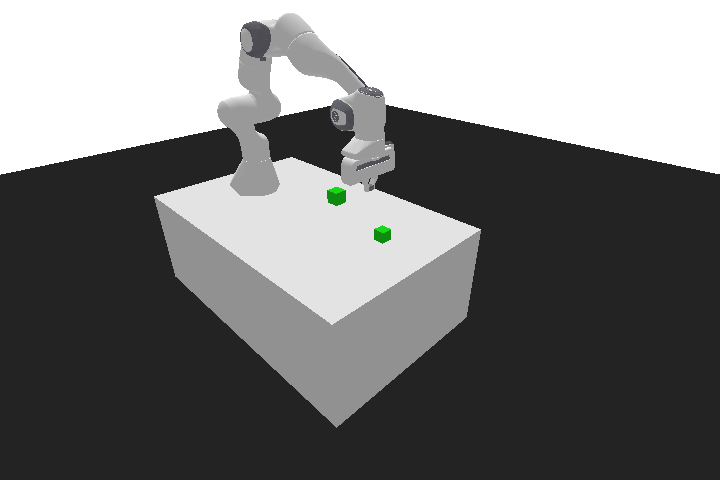

In [13]:
#redering the simulation

from IPython.display import Image

Image(filename="anim.png")